In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.utils import shuffle

# Load and Resize Image

(397, 265, 3)


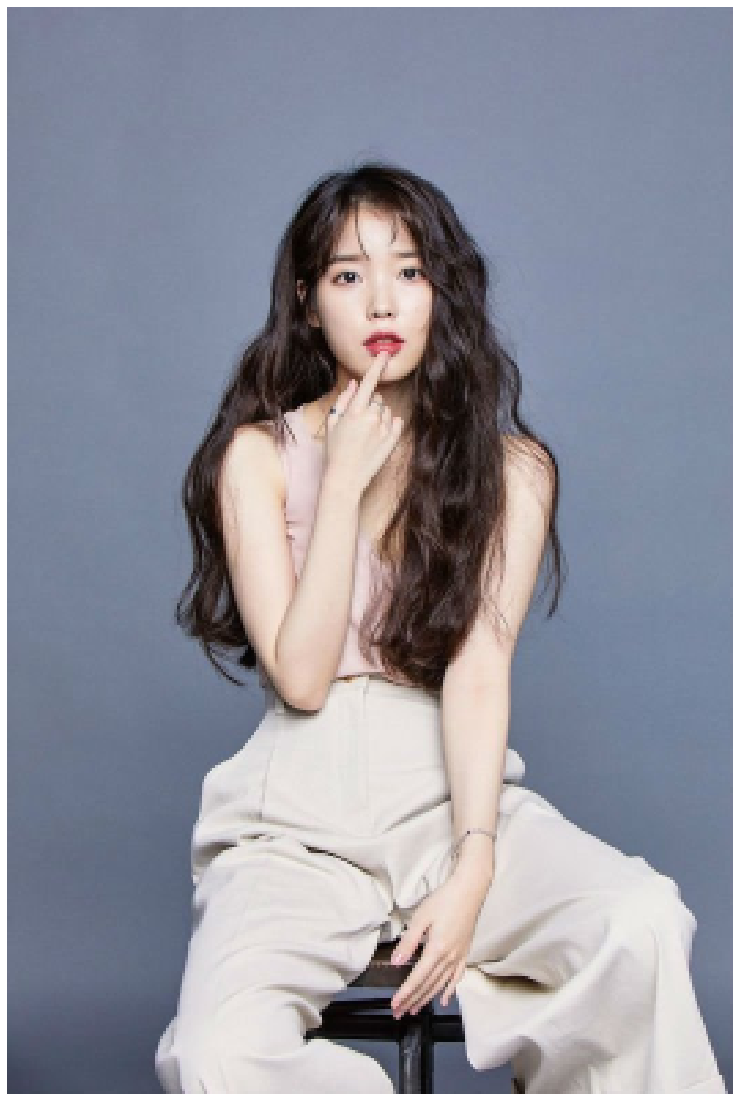

In [2]:
img_path = 'img/iu.jpg'
img = cv2.imread(img_path)

img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

# Load and Preview Patch Images (CiFAR-10)

(50000, 32, 32, 3)


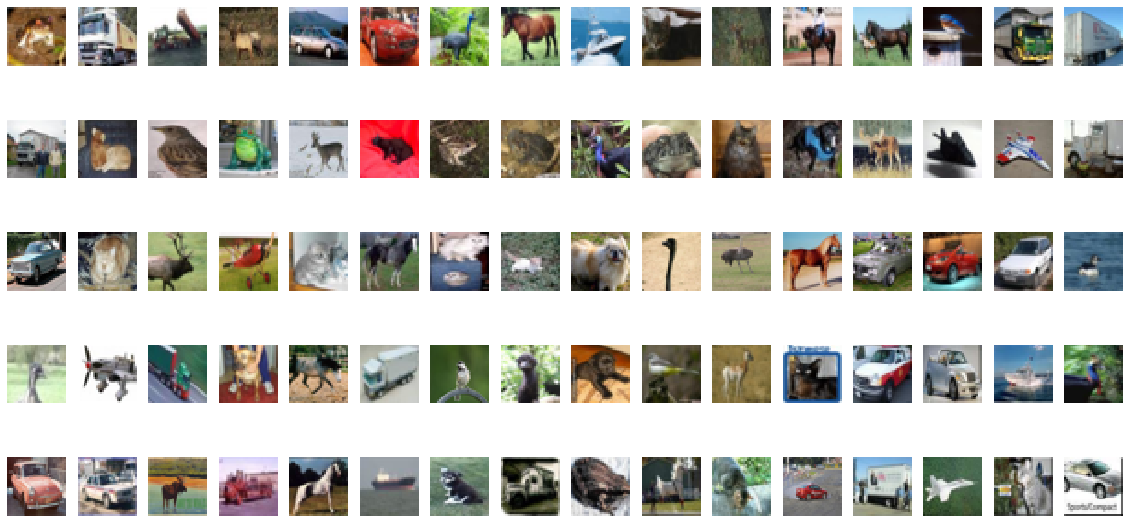

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    data = dict[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1).astype(np.float64) / 255.

    return data

x_train_1 = unpickle('dataset/data_batch_1')
x_train_2 = unpickle('dataset/data_batch_2')
x_train_3 = unpickle('dataset/data_batch_3')
x_train_4 = unpickle('dataset/data_batch_4')
x_train_5 = unpickle('dataset/data_batch_5')

sample_imgs = np.concatenate([x_train_1, x_train_2, x_train_3, x_train_4, x_train_5], axis=0)

print(sample_imgs.shape)

plt.figure(figsize=(20, 10))
for i in range(80):
    img_patch = sample_imgs[i]

    plt.subplot(5, 16, i+1)
    plt.axis('off')
    plt.imshow(img_patch)

# KMean Clustering for Image Quantization

In [4]:
N_CLUSTERS = 32

h, w, d = img.shape

img_array = img.copy().astype(np.float64) / 255.
img_array = np.reshape(img_array, (w * h, d))

# all pixels
#img_array_sample = shuffle(img_array, random_state=0)

# pick random 1000 pixels if want to run faster
img_array_sample = shuffle(img_array, random_state=0)[:1000]

# KMeans clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(img_array_sample)

print(kmeans.cluster_centers_)

[[0.50648183 0.54969402 0.63651805]
 [0.91128376 0.89322974 0.8836108 ]
 [0.21643324 0.17852474 0.17535014]
 [0.33594771 0.35477124 0.43137255]
 [0.88491049 0.76811594 0.71679454]
 [0.05779154 0.03962848 0.04045408]
 [0.42438503 0.46566845 0.5485205 ]
 [0.52370766 0.42245989 0.38431373]
 [0.61895425 0.49738562 0.45555556]
 [0.70718954 0.6745098  0.66732026]
 [0.88169935 0.86681191 0.86623094]
 [0.46279956 0.50571895 0.59242919]
 [0.19379085 0.13627451 0.12287582]
 [0.9105042  0.8267507  0.77857143]
 [0.31808279 0.28061002 0.29368192]
 [0.75843137 0.73960784 0.73843137]
 [0.39313725 0.42736185 0.50828877]
 [0.77875817 0.65392157 0.59477124]
 [0.13810742 0.09360614 0.08371697]
 [0.84984187 0.82820999 0.83048703]
 [0.52631579 0.56828345 0.65782594]
 [0.93477812 0.86769866 0.82600619]
 [0.61786492 0.56906318 0.54771242]
 [0.48459384 0.32268908 0.28627451]
 [0.81911765 0.70637255 0.6745098 ]
 [0.4873081  0.53029336 0.61784466]
 [0.39058824 0.26352941 0.21882353]
 [0.8147813  0.78310709 0.79

# Plot Quantized Image

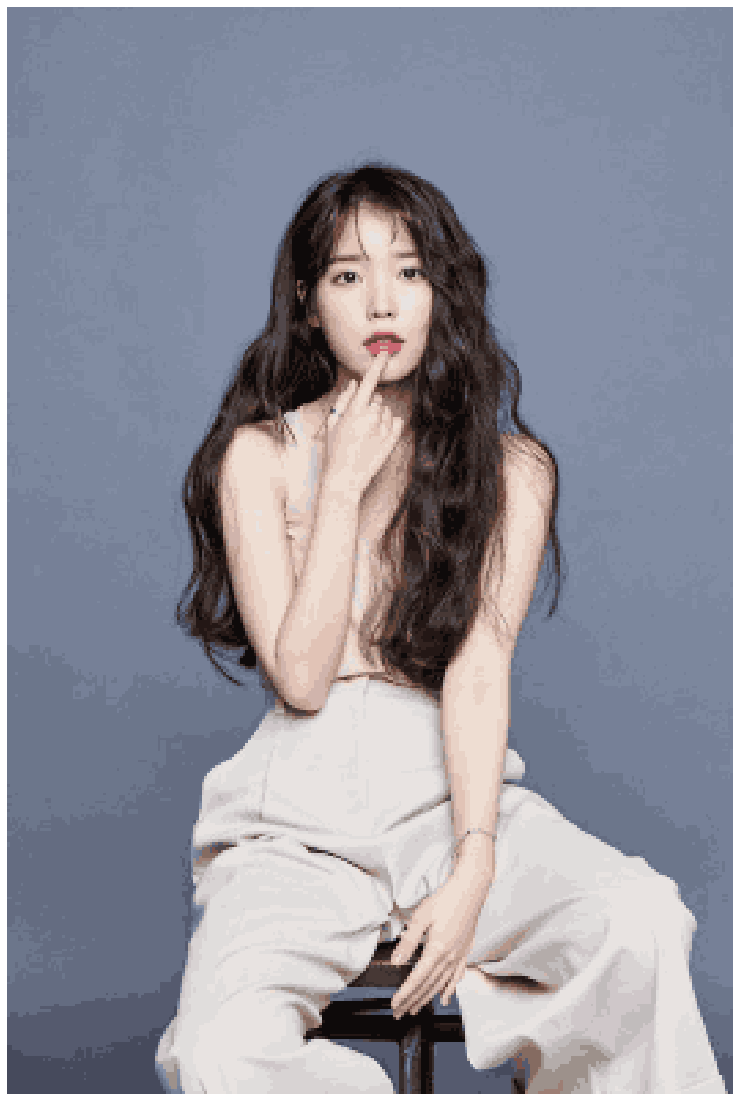

In [5]:
cluster_centers = kmeans.cluster_centers_

pred_labels = kmeans.predict(img_array)
cluster_labels = pred_labels.reshape((h, w))

img_quantized = np.zeros((h, w, d), dtype=np.float64)

label_idx = 0
for y in range(h):
    for x in range(w):
        label = pred_labels[label_idx]

        img_quantized[y, x] = cluster_centers[label]

        label_idx += 1

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img_quantized)

# Compute Distance of Pixels and Patches

In [6]:
DISTANCE_THRESHOLD = 0.1

bins = defaultdict(list)

for img_patch in sample_imgs:
    mean = np.mean(img_patch, axis=(0, 1))

    # compare patch mean and cluster centers
    cluster_idx, distance = pairwise_distances_argmin_min(cluster_centers, [mean], axis=0)
    
    if distance < DISTANCE_THRESHOLD:
        bins[cluster_idx[0]].append(img_patch)

# number of bins must equal to N_CLUSTERS. if not, increase DISTANCE_THRESHOLD
assert(len(bins) == N_CLUSTERS)

# Fill Images

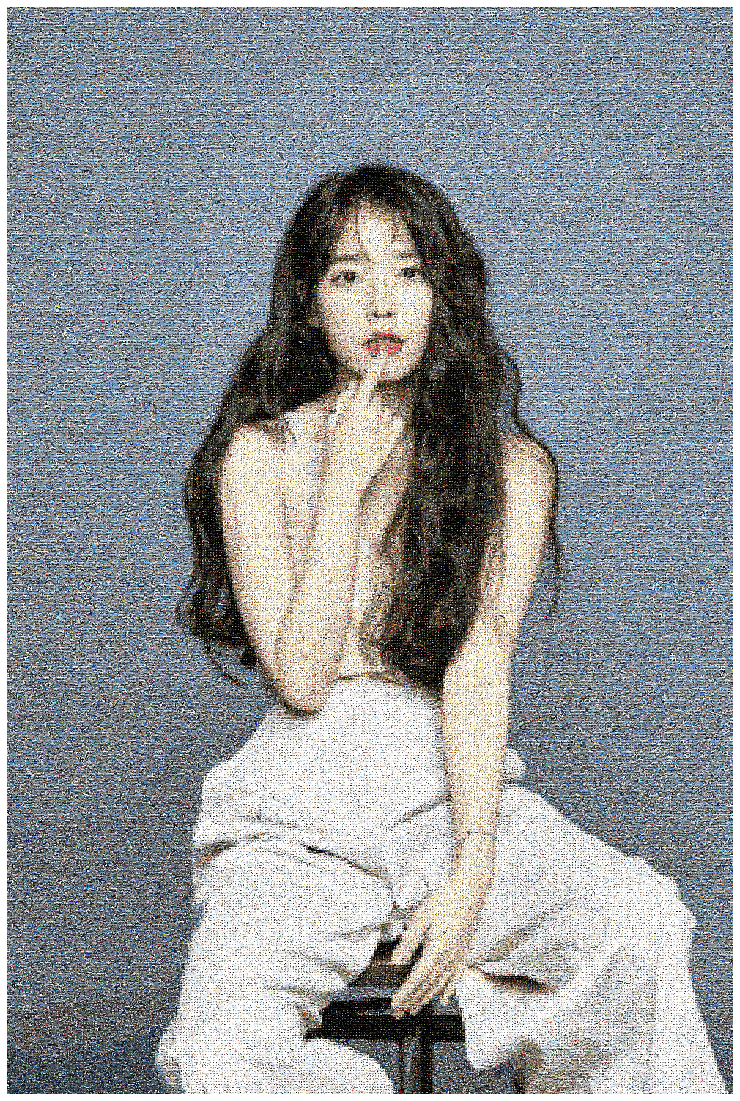

In [7]:
img_out = np.zeros((h*32, w*32, d), dtype=np.float64)

for y in range(h):
    for x in range(w):
        label = cluster_labels[y, x]

        b = bins[label]

        img_patch = b[np.random.randint(len(b))]

        img_out[y*32:(y+1)*32, x*32:(x+1)*32] = img_patch
        
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img_out)

img_out2 = cv2.cvtColor((img_out * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
_ = cv2.imwrite('result/%s_color.jpg' % os.path.splitext(os.path.basename(img_path))[0], img_out2)